Extract the details about the current resources in the Galaxy Training Material and some statistics

In [1]:
!type python

python is /Users/bebatut/miniconda3/envs/galaxy-training-material-stats/bin/python


In [2]:
import base64
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import yaml

from github import Github
from pprint import pprint

1. Generate a Personal access tokens on GitHub (in Setting)
2. Add it to the `../config.yaml` after `github:`

In [3]:
with open("../config.yaml", "r") as stream:
    config = yaml.load(stream)

In [4]:
# connect to GitHub
g = Github(config["github"])
# retrieve the hub repository
repo = g.get_user("galaxyproject").get_repo("training-material")

In [74]:
# dates and corresponding commit
gitcommit_dates = {
    "22.06.17": "44164c9b",
    "22.06.18": "24ea24ef",
    datetime.datetime.now().strftime("%d.%m.%y"): "master"}

# Extract training content

In [6]:
def get_yaml_content(file_content):
    '''
    Extract the YAML content of the file from GitHub

    :param file_content: the encoded content of the file obtained with GitHub API

    :return: content in YAML of the file
    '''
    decoded_file_content = base64.b64decode(file_content)
    yaml_content = yaml.load(decoded_file_content)
    return yaml_content

In [65]:
def extract_training_content(ref):
    '''
    Extract the details about the current resources in the Galaxy Training Material

    :param ref: name of the commit/branch/tag

    :return: dictionary with information about the tutorials in each topic on ref
    '''
    trainings = {}
    topics_dir = "topics"
    for topic in repo.get_dir_contents("topics", ref):
        # get topic details
        topic_n = topic.name
        print(topic_n)
        if topic_n == 'instructors':
            continue
        trainings.setdefault(topic_n, {})
        # parse the tutorials
        for tuto in repo.get_dir_contents("%s/tutorials/" % topic.path, ref):
            tuto_n = tuto.name
            print(" %s" % tuto_n)
            trainings[topic_n].setdefault(tuto_n, {})
            infos = ['hands_on', 'slides', 'galaxy_tour', 'workflows', 'data_library']
            for info in infos:
                trainings[topic_n][tuto_n][info] = False
            # parse the tuto content
            for tuto_content in repo.get_dir_contents(tuto.path, ref):
                if tuto_content.name == 'slides.html':
                    trainings[topic_n][tuto_n]['slides'] = True
                elif tuto_content.name == 'tutorial.md':
                    trainings[topic_n][tuto_n]['hands_on'] = True
                elif tuto_content.name == 'tours':
                    trainings[topic_n][tuto_n]['galaxy_tour'] = True
                elif tuto_content.name == 'workflows':
                    trainings[topic_n][tuto_n]['workflows'] = True
                elif tuto_content.name == 'data_library.yaml':
                    trainings[topic_n][tuto_n]['data_library'] = True
    return trainings

In [75]:
# extract training content
training_contents = {}
for d, git_com in gitcommit_dates.items():
    training_contents[d] = extract_training_content(git_com)

admin
 advanced-galaxy-customisation
 database-schema
 dev-to-production
 galaxy-docker
assembly
 debruijn-graph-assembly
 general-introduction
chip-seq
 chip-seq
 tal1-binding-site-identification
dev
 architecture
 bioblend-api
 conda
 containers
 data-source-integration
 github-contribution
 interactive-environments
 interactive-tours
 tool-integration
 toolshed
 visualization-charts
 visualization-generic
 webhooks
epigenetics
 methylation-seq
introduction
 galaxy-intro-101
 galaxy-intro-collections
 galaxy-intro-get-data
 galaxy-intro-peaks2genes
 galaxy-intro-vis
 igv-introduction
 options-for-using-galaxy
 processing-many-samples-at-once
metagenomics
 general-tutorial
 mothur-miseq-sop
proteomics
 database-handling
 labelfree-vs-labelled
 metaproteomics
 ntails
 protein-id-sg-ps
 protein-quant-sil
 secretome-prediction
sequence-analysis
 de-novo-rad-seq
 genetic-map-rad-seq
 genome-annotation
 mapping
 quality-control
 ref-based-rad-seq
 srna
training
 create-new-tutorial-content

# Extract stats

In [76]:
def extract_training_stats(content, date):
    '''
    Extract the details about the current resources in the Galaxy Training Material

    :param content: dictionary with information about the tutorials in each topic on GitHub at the date given
    :param date: date corresponding

    :return: dictionary with some statistics about the training content on ref
    '''
    stats = pd.DataFrame({'topics': 0,
                          'tutorials': 0,
                          'hands_on': 0,
                          'slides': 0,
                          'galaxy_tour': 0,
                          'workflows': 0,
                          'zenodo_link': 0,
                          'tools': 0,
                          'data_library': 0},
                          index=[date])
    # extract stats
    hands_on_info = ["tools", "galaxy_tour", "workflows", "zenodo_link", "data_library"]
    no_hands_on_topic = ["Development in Galaxy", "Contributing to the Galaxy Training Material", "Train the trainers", "Galaxy Server administration"]
    for topic in content:
        stats.loc[date,'topics'] += 1
        for tuto in content[topic]:
            stats.loc[date,'tutorials'] += 1
            for info in list(stats.columns):
                if info in content[topic][tuto]:
                    if content[topic][tuto][info]:
                        if info in hands_on_info and topic in no_hands_on_topic:
                            continue
                        if content[topic][tuto][info] == "no":
                            continue
                        if content[topic][tuto][info] == "external":
                            continue
                        if content[topic][tuto][info] == "url to Zenodo with input data":
                            continue
                        stats.loc[date,info] += 1
                    elif info in hands_on_info and topic not in no_hands_on_topic:
                        print("%s - %s (%s)" % (topic, tuto, info))
    # reindex
    stats = stats[['topics','tutorials','hands_on','slides','tools','workflows','zenodo_link','data_library','galaxy_tour']]
    # rename columns
    stats = stats.rename(columns={"topics":"Topics",
                                  "tutorials":"Tutorials",
                                  "hands_on":"Hands-on",
                                  "slides":"Slide decks",
                                  "tools": "Tools",
                                  "workflows": "Worflows",
                                  "zenodo_link": "Data on Zenodo",
                                  "data_library": "Data for data libraries",
                                  "galaxy_tour": "Interactive tours"})
    return stats

In [77]:
# extract stats
training_stats = {}
for d, cont in training_contents.items():
    print(d)
    training_stats[d] = extract_training_stats(cont, d)
    print()

22.06.17
admin - advanced-galaxy-customisation (galaxy_tour)
admin - advanced-galaxy-customisation (workflows)
admin - advanced-galaxy-customisation (data_library)
admin - database-schema (galaxy_tour)
admin - database-schema (workflows)
admin - database-schema (data_library)
admin - dev-to-production (galaxy_tour)
admin - dev-to-production (workflows)
admin - dev-to-production (data_library)
admin - galaxy-docker (galaxy_tour)
admin - galaxy-docker (workflows)
admin - galaxy-docker (data_library)
assembly - debruijn-graph-assembly (galaxy_tour)
assembly - debruijn-graph-assembly (workflows)
assembly - debruijn-graph-assembly (data_library)
assembly - general-introduction (galaxy_tour)
assembly - general-introduction (data_library)
chip-seq - chip-seq (galaxy_tour)
chip-seq - chip-seq (workflows)
chip-seq - chip-seq (data_library)
chip-seq - tal1-binding-site-identification (data_library)
dev - architecture (galaxy_tour)
dev - architecture (workflows)
dev - architecture (data_library)


sequence-analysis - ref-based-rad-seq (data_library)
statistics - iwtomics (data_library)
transcriptomics - de-novo (data_library)
transcriptomics - rb-rnaseq (galaxy_tour)
transcriptomics - rb-rnaseq (workflows)
transcriptomics - rb-rnaseq (data_library)
transcriptomics - ref-based (data_library)
transcriptomics - rna-seq-viz-with-cummerbund (data_library)
transcriptomics - srna (data_library)
variant-analysis - dip (galaxy_tour)
variant-analysis - dip (workflows)
variant-analysis - dip (data_library)
variant-analysis - diploid-variant-calling (data_library)
variant-analysis - dunovo (galaxy_tour)
variant-analysis - dunovo (workflows)
variant-analysis - dunovo (data_library)
variant-analysis - exome-seq (data_library)
variant-analysis - mapping-by-sequencing (galaxy_tour)
variant-analysis - mapping-by-sequencing (data_library)
variant-analysis - microbial-variants (galaxy_tour)
variant-analysis - microbial-variants (data_library)
variant-analysis - non-dip (galaxy_tour)
variant-analys

In [81]:
training_stats

{'22.06.17':           Topics  Tutorials  Hands-on  Slide decks  Tools  Worflows  \
 22.06.17      13         63        49           21      0        23   
 
           Data on Zenodo  Data for data libraries  Interactive tours  
 22.06.17               0                        0                 20  ,
 '22.06.18':           Topics  Tutorials  Hands-on  Slide decks  Tools  Worflows  \
 22.06.18      14         86        68           31      0        32   
 
           Data on Zenodo  Data for data libraries  Interactive tours  
 22.06.18               0                        0                 30  ,
 '12.11.18':           Topics  Tutorials  Hands-on  Slide decks  Tools  Worflows  \
 12.11.18      16         95        77           36      0        39   
 
           Data on Zenodo  Data for data libraries  Interactive tours  
 12.11.18               0                        1                 33  }

In [82]:
# combine stats
all_stats = pd.concat(training_stats.values())
print(all_stats)

          Topics  Tutorials  Hands-on  Slide decks  Tools  Worflows  \
22.06.17      13         63        49           21      0        23   
22.06.18      14         86        68           31      0        32   
12.11.18      16         95        77           36      0        39   

          Data on Zenodo  Data for data libraries  Interactive tours  
22.06.17               0                        0                 20  
22.06.18               0                        0                 30  
12.11.18               0                        1                 33  


In [83]:
# export to csv
all_stats.to_csv("../data/repo_content_stats", index = True)

# Plot number of topics, tutorials, etc

In [84]:
content_stats = all_stats[["Topics", "Tutorials", "Hands-on", "Slide decks"]].transpose()

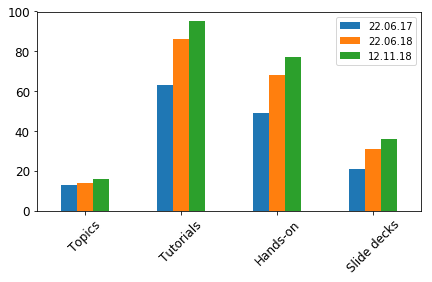

In [87]:
# plot barplot stats
ax = content_stats.plot(kind='bar', legend=True, fontsize=12)
ax.set_xticklabels(content_stats.index, rotation=45)
plt.tight_layout()
plt.savefig("../images/repo_content_stat_plot.png", transparent=True, dpi=150)

In [88]:
# extract proportions
prop = pd.DataFrame({'Both hands-on and slide deck': 0,
                     'Only hands-on': 0,
                     'Only slide deck': 0},
                     index=all_stats.index)
prop['Both hands-on and slide deck'] = (all_stats['Hands-on'] + all_stats['Slide decks'] - all_stats['Tutorials'])/all_stats['Tutorials']
prop['Only hands-on'] = all_stats['Hands-on']/all_stats['Tutorials'] - prop['Both hands-on and slide deck']
prop['Only slide deck'] = all_stats['Slide decks']/all_stats['Tutorials'] - prop['Both hands-on and slide deck']
prop = prop * 100
print(prop)

          Both hands-on and slide deck  Only hands-on  Only slide deck
22.06.17                     11.111111      66.666667        22.222222
22.06.18                     15.116279      63.953488        20.930233
12.11.18                     18.947368      62.105263        18.947368


# Plot percentages of covered hands-on tutorials

In [89]:
tech_support_stats = all_stats[["Tools", "Worflows", "Data on Zenodo", "Data for data libraries", "Interactive tours"]].transpose()

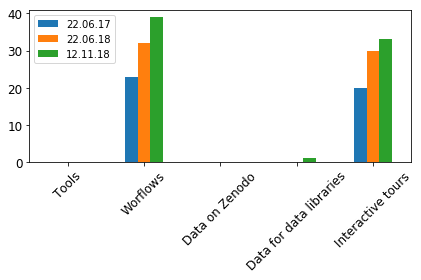

In [91]:
# plot barplot stats
ax = tech_support_stats.plot(kind='bar', legend=True, fontsize=12)
ax.set_xticklabels(tech_support_stats.index, rotation=45)
plt.tight_layout()
plt.savefig("../images/tech_support_stat_plot.png", transparent=True, dpi=150)

In [92]:
# extract proportions
tech_support_perc = tech_support_stats
for d in list(all_stats.index):
    tech_support_perc[[d]] = 100 * tech_support_perc[[d]]/all_stats.loc[d,"Hands-on"]
print(tech_support_perc)

                          22.06.17   22.06.18   12.11.18
Tools                     0.000000   0.000000   0.000000
Worflows                 46.938776  47.058824  50.649351
Data on Zenodo            0.000000   0.000000   0.000000
Data for data libraries   0.000000   0.000000   1.298701
Interactive tours        40.816327  44.117647  42.857143


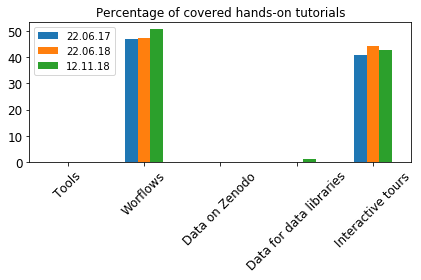

In [94]:
# plot percentage stats
ax = tech_support_perc.plot(kind='bar', legend = True, fontsize=12, title="Percentage of covered hands-on tutorials")
ax.set_xticklabels(tech_support_perc.index, rotation=45)
plt.tight_layout()
plt.savefig("../images/tech_support_prop_plot.png", transparent=True, dpi=150)